# Stock-Predictor using LSTM

### Import libraries

In [1]:
import datetime as dt
from finta import TA

import pandas as pd
from pandas_datareader import data as web
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from numpy import size
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
from keras.callbacks import History 

np.warnings.filterwarnings('ignore')

### Load data and pre-processing

In [2]:
def get_stock_data(symbol, start_date, end_date):
    '''
    download stock data over from yahoo api form start date to end date
    input
        stock - String representing stock symbol eg APPL
        start - datetime object represent start date; default Jan 1, 2010
        end - datetime object represent end date; default: Jan 1, 2020
    output
        historical stock data pulled from yahoo finance stock api from start to end dates
    '''
    stockData = web.DataReader(symbol, 'yahoo', start_date, end_date)
    
    return stockData

start_date = dt.datetime(2004, 10, 1)
end_date = dt.datetime(2022, 10, 1)
df_GOOG = get_stock_data('GOOG',start_date, end_date)
df_GOOG.tail(4)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-09-27,100.459999,97.339996,99.910004,98.089996,24225000.0,98.089996
2022-09-28,101.400002,97.800003,98.019997,100.739998,24617000.0,100.739998
2022-09-29,99.300003,96.519997,99.300003,98.089996,21921500.0,98.089996
2022-09-30,99.494003,96.029999,97.730003,96.150002,26248200.0,96.150002


In [3]:
#Renaming columns
df_GOOG.rename(columns = {'High':'high', 'Low': 'low', 'Open':'open','Volume':'volume', 'Adj Close':'adj_close'}, inplace = True)

### Adding features

Additional features were added in order to increase the accuracy of the prediction. The features are in the form of technical indicators used to measure the performance of the stock in various ways. There are different types of technical indicators, namely: **trend, momentum, volatility and volume**. 

For best results, it is advised to use a mixture of techincal indicators. Otherwise, using many indicators of the same type will result in **multicollinearity**, overblowing the results

In this analysis the following techincal indicators were chosen:

Relative Strength Index (RSI) - Used as a momentum indicator commonly used to determine the strength of price changes in market. 

On Balance Volume - Used as a volume indicator, calculating the buying and selling pressures of a stock

Bollinger Bands -  Used as a volatility and trend indicator, plots three trend lines, determining whether a stock is overbought or oversold.

In [4]:
rsi = TA.RSI(df_GOOG)
obv = TA.OBV(df_GOOG)
bbands = TA.BBANDS(df_GOOG, 21)

df_GOOG['OBV'] = obv.values
df_GOOG = pd.concat([df_GOOG, rsi], axis = 1)
df_GOOG = pd.concat([df_GOOG, bbands], axis = 1)
df_GOOG = df_GOOG.dropna()
df_GOOG.describe()

,high,low,open,Close,volume,adj_close,OBV,14 period RSI,BB_UPPER,BB_MIDDLE,BB_LOWER
count,4511.000000,4511.000000,4511.000000,4511.000000,4.511000e+03,4511.000000,4.511000e+03,4511.000000,4511.000000,4511.000000,4511.000000
mean,37.576318,36.823572,37.200643,37.205834,1.227037e+08,37.205834,2.016020e+10,54.217064,39.072900,36.990104,34.907309
std,35.182853,34.445349,34.809058,34.815612,1.505469e+08,34.815612,3.846793e+09,12.633815,36.664160,34.684090,32.755789
min,4.221676,4.017691,4.096396,4.112087,1.584340e+05,4.112087,-8.102176e+08,21.330543,4.602334,3.816469,2.743964
25%,12.826547,12.538752,12.695290,12.676859,3.014000e+07,12.676859,1.919959e+10,44.767545,13.464443,12.686246,11.697362
50%,23.112617,22.821959,23.021212,22.988832,6.859214e+07,22.988832,2.112246e+10,53.936424,23.350873,22.487651,21.638335
75%,53.558750,52.362125,52.915998,53.011000,1.530796e+08,53.011000,2.180190e+10,63.436345,55.625090,52.866928,50.030339
max,152.100006,149.887497,151.863495,150.709000,1.650833e+09,150.709000,2.668921e+10,90.929456,154.074570,147.882762,144.401245


### Visualizing the data

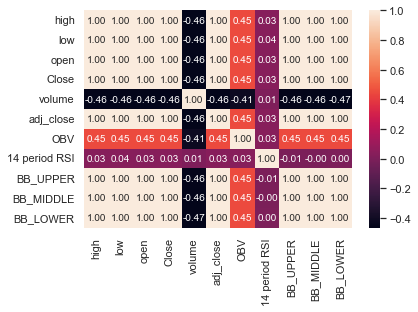

In [5]:
sns.set (rc = {'figure.figsize':(12, 8)})
sns.heatmap(df_GOOG.corr(), annot=True,fmt='.2f');

As expected most variables are highly correlated to each other. Exceptions are made by the RSI, which is understandable given that it is more linked to the future price rather than the current one.

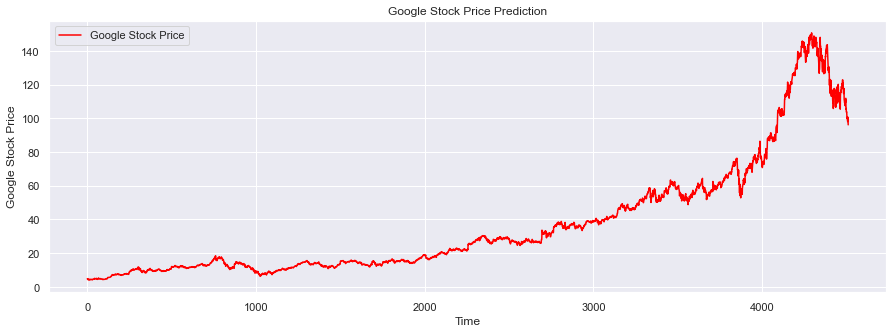

In [6]:
# Visualising the results
plt.figure(2, figsize=(15,5))
plt.plot(df_GOOG.loc[:, ['adj_close']].values, color = "red", label = "Google Stock Price")
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

# Basic model

In [7]:
# history_points = 21
# train_split = 0.7
# #Preparation of train test set.
# train_indices = int(df_GOOG.shape[0] * train_split)

# train_data = df_GOOG[:train_indices]
# test_data = df_GOOG[train_indices:]

# test_data = test_data.reset_index()
# test_data = test_data.drop(columns = ['Date'])

# normaliser = preprocessing.MinMaxScaler()
# train_normalised_data = normaliser.fit_transform(train_data)

# test_normalised_data = normaliser.transform(test_data)

# X_train = np.array([train_normalised_data[:,0:][i : i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])

# y_train = np.array([train_normalised_data[:,0][i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])
# y_train = np.expand_dims(y_train, -1)

# y_normaliser = preprocessing.MinMaxScaler()
# next_day_close_values = np.array([train_data['adj_close'][i + history_points].copy() for i in range(len(train_data) - history_points)])
# next_day_close_values = np.expand_dims(next_day_close_values, -1)

# y_normaliser.fit(next_day_close_values)

    
# X_test = np.array([test_normalised_data[:,0:][i  : i + history_points].copy() for i in range(len(test_normalised_data) - history_points)])


# y_test = np.array([test_data['adj_close'][i + history_points].copy() for i in range(len(test_data) - history_points)])

# y_test = np.expand_dims(y_test, -1)

In [8]:
# # model architecture
# tf.random.set_seed(20)
# np.random.seed(10)

# lstm_input = Input(shape=(history_points, 11), name='input_for_lstm')

# inputs = LSTM(21, name='first_layer', return_sequences = True)(lstm_input)

# inputs = Dropout(0.1, name='first_dropout_layer')(inputs)
# inputs = LSTM(32, name='lstm_1')(inputs)
# inputs = Dropout(0.05, name='lstm_dropout_1')(inputs) #Dropout layers to prevent overfitting
# inputs = Dense(32, name='first_dense_layer')(inputs)
# inputs = Dense(1, name='dense_layer')(inputs)
# output = Activation('linear', name='output')(inputs)

# model = Model(inputs=lstm_input, outputs=output)
# adam = optimizers.Adam(lr = 0.002)

# model.compile(optimizer=adam, loss='mse')
# model.fit(x=X_train, y=y_train, batch_size=15, epochs=25, shuffle=True, validation_split = 0.1)


Epoch 1/25
189/189 [==============================] - 5s 13ms/step - loss: 0.0040 - val_loss: 0.0089
Epoch 2/25
189/189 [==============================] - 2s 9ms/step - loss: 8.2895e-04 - val_loss: 8.3832e-04
Epoch 3/25
189/189 [==============================] - 2s 9ms/step - loss: 5.9315e-04 - val_loss: 4.3362e-04
Epoch 4/25
189/189 [==============================] - 2s 9ms/step - loss: 4.8435e-04 - val_loss: 3.4920e-04
Epoch 5/25
189/189 [==============================] - 2s 9ms/step - loss: 5.3330e-04 - val_loss: 2.6715e-04
Epoch 6/25
189/189 [==============================] - 2s 9ms/step - loss: 4.3355e-04 - val_loss: 0.0014
Epoch 7/25
189/189 [==============================] - 2s 9ms/step - loss: 3.6745e-04 - val_loss: 5.0362e-04
Epoch 8/25
189/189 [==============================] - 2s 9ms/step - loss: 3.4288e-04 - val_loss: 2.4304e-04
Epoch 9/25
189/189 [==============================] - 2s 9ms/step - loss: 3.0274e-04 - val_loss: 4.9474e-04
Epoch 10/25
189/189 [==================

42/42 [==============================] - 1s 3ms/step


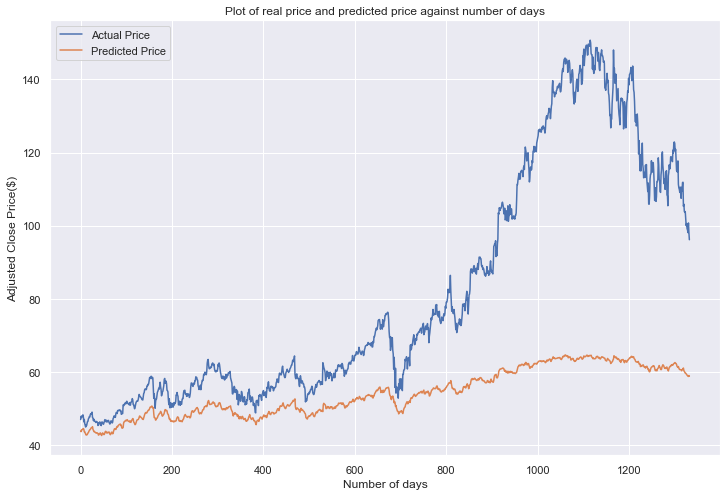

In [9]:
# y_pred = model.predict(X_test)
# y_pred = y_normaliser.inverse_transform(y_pred)

# real = plt.plot(y_test, label='Actual Price')
# pred = plt.plot(y_pred, label='Predicted Price')

# plt.gcf().set_size_inches(12, 8, forward=True)
# plt.title('Plot of real price and predicted price against number of days')
# plt.xlabel('Number of days')
# plt.ylabel('Adjusted Close Price($)')

# plt.legend(['Actual Price', 'Predicted Price'])

In [7]:
df = df_GOOG.reset_index()
df = df.drop(['Close','Date'], axis=1)

#Calculate the index of split
split_index = int(df.shape[0] * 0.7)

#Split data
train_data = df[:split_index]
test_data = df[split_index:]

#Normalize the variables
normaliser = preprocessing.MinMaxScaler(feature_range=(0,1))
#Creating a specific scaler for the y values
y_normaliser = preprocessing.MinMaxScaler(feature_range=(0,1))
train_normalised = normaliser.fit_transform(train_data)
x_train_normalised = np.delete(train_normalised, np.s_[4], 1)
y_train_normalised = train_normalised[:,4]
test_normalised = normaliser.transform(test_data)
x_test_normalised = np.delete(test_normalised, np.s_[4], 1)
y_norm = y_normaliser.fit_transform(train_data.loc[:, ['adj_close']].values)

#Prepare train datasets by 
X_train = []
y_train = []

for i in range(21, train_data.shape[0]):
    X_train.append(x_train_normalised[i-21:i,0])
    y_train.append(y_train_normalised[i- 1] - y_train_normalised[i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test = []
for i in range(21, test_data.shape[0]):
    X_test.append(x_test_normalised[i-21:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [23]:
df = df_GOOG.reset_index()
df = df.drop(['Close','Date'], axis=1)

#Calculate the index of split
split_index = int(df.shape[0] * 0.7)

#Split data
train_data = df[:split_index]
test_data = df[split_index:]

In [15]:
df = df_GOOG.reset_index()
df = df.drop(['Close','Date'], axis=1)

#Calculate the index of split
split_index = int(df.shape[0] * 0.7)


#Split data
train_data = df[:split_index]
test_data = df[split_index:]

#Normalize the variables
normaliser = preprocessing.MinMaxScaler(feature_range=(0,1))
#Creating a specific scaler for the y values
y_normaliser = preprocessing.MinMaxScaler(feature_range=(0,1))
train_normalised = normaliser.fit_transform(train_data)
X_train, y_train = split_sequences(train_normalised, 21)

#x_train_normalised = np.delete(train_normalised, np.s_[4], 1)
#y_train_normalised = train_normalised[:,4]
test_normalised = normaliser.transform(test_data)

X_test, y_test = split_sequences(test_normalised, 21)
#x_test_normalised = np.delete(test_normalised, np.s_[4], 1)
y_norm = y_normaliser.fit_transform(train_data.loc[:, ['adj_close']].values)

In [17]:
y_test

array([1.12611167, 1.13156366, 1.13662232, ..., 2.42667963, 2.40543804,
       2.37708947])

In [24]:
train_data

,high,low,open,volume,adj_close,OBV,14 period RSI,BB_UPPER,BB_MIDDLE,BB_LOWER
0,4.980083,4.747206,4.953682,849672890.0,4.748203,3.482095e+09,78.792214,4.888974,3.816469,2.743964
1,4.923296,4.763894,4.820681,490828877.0,4.882449,3.972924e+09,80.521934,5.032264,3.891722,2.751181
2,4.962649,4.815451,4.950943,455553149.0,4.853558,3.517371e+09,79.028080,5.149674,3.962659,2.775644
3,5.021179,4.750942,4.935999,557630330.0,4.773856,2.959740e+09,74.899848,5.238520,4.025874,2.813228
4,4.742225,4.566633,4.693408,578544429.0,4.600257,2.381196e+09,66.724069,5.285793,4.082353,2.878913
...,...,...,...,...,...,...,...,...,...,...
3152,46.599998,46.257999,46.598999,23478000.0,46.438999,2.143533e+10,80.183712,48.232975,43.965143,39.697311
3153,46.626499,46.151501,46.265999,16700000.0,46.529999,2.145203e+10,80.643331,48.426550,44.220500,40.014450
3154,46.672001,46.392502,46.576500,21012000.0,46.611000,2.147304e+10,81.064341,48.570222,44.477405,40.384588
3155,46.912498,46.466999,46.647499,22162000.0,46.854000,2.149520e+10,82.307563,48.671560,44.747691,40.823822


In [25]:
train_data['high_diff'] = 0
train_data['low_diff'] = 0
train_data['open_diff'] = 0
train_data['volume_diff'] = 0
train_data['adj_close_diff'] = 0
train_data['OBV_diff'] = 0
train_data['14 period RSI_diff'] = 0
train_data['BB_UPPER_diff'] = 0
train_data['BB_MIDDLE_diff'] = 0
train_data['BB_LOWER_diff'] = 0

for i in range(train_data.shape[0]):
    if i == 0:
        train_data['high_diff'].iloc[i] = train_data['high'].iloc[i]
        train_data['low_diff'].iloc[i] = train_data['low'].iloc[i]
        train_data['open_diff'].iloc[i] = train_data['open'].iloc[i]
        train_data['volume_diff'].iloc[i] = train_data['volume'].iloc[i]
        train_data['adj_close_diff'].iloc[i] = train_data['adj_close'].iloc[i]
        train_data['OBV_diff'].iloc[i] = train_data['OBV'].iloc[i]
        train_data['14 period RSI_diff'].iloc[i] = train_data['14 period RSI'].iloc[i]
        train_data['BB_UPPER_diff'].iloc[i] = train_data['BB_UPPER'].iloc[i]
        train_data['BB_MIDDLE_diff'].iloc[i] = train_data['BB_MIDDLE'].iloc[i]
        train_data['BB_LOWER_diff'].iloc[i] = train_data['BB_LOWER'].iloc[i]
    else:
        train_data['high_diff'].iloc[i] = train_data['high'].iloc[i] - train_data['high'].iloc[i - 1]
        train_data['low_diff'].iloc[i] = train_data['low'].iloc[i] - train_data['low'].iloc[i - 1]
        train_data['open_diff'].iloc[i] = train_data['open'].iloc[i] - train_data['open'].iloc[i - 1]
        train_data['volume_diff'].iloc[i] = train_data['volume'].iloc[i] - train_data['volume'].iloc[i - 1]
        train_data['adj_close_diff'].iloc[i] = train_data['adj_close'].iloc[i] - train_data['adj_close'].iloc[i - 1]
        train_data['OBV_diff'].iloc[i] = train_data['OBV'].iloc[i] - train_data['OBV'].iloc[i - 1]
        train_data['14 period RSI_diff'].iloc[i] = train_data['14 period RSI'].iloc[i] - train_data['14 period RSI'].iloc[i - 1]
        train_data['BB_UPPER_diff'].iloc[i] = train_data['BB_UPPER'].iloc[i] - train_data['BB_UPPER'].iloc[i - 1]
        train_data['BB_MIDDLE_diff'].iloc[i] = train_data['BB_MIDDLE'].iloc[i] - train_data['BB_MIDDLE'].iloc[i - 1]
        train_data['BB_LOWER_diff'].iloc[i] = train_data['BB_LOWER'].iloc[i] - train_data['BB_LOWER'].iloc[i - 1]


train_data = train_data.drop(['high', 'low', 'open', 'volume', 'adj_close', 'OBV', '14 period RSI', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER'], axis=1)
train_data = train_data[1:]
train_data



,high_diff,low_diff,open_diff,volume_diff,adj_close_diff,OBV_diff,14 period RSI_diff,BB_UPPER_diff,BB_MIDDLE_diff,BB_LOWER_diff
1,-0.056787,0.016688,-0.133001,-358844013,0.134246,490828877,1.729720,0.143290,0.075254,0.007217
2,0.039353,0.051557,0.130262,-35275728,-0.028891,-455553149,-1.493853,0.117410,0.070937,0.024463
3,0.058530,-0.064509,-0.014944,102077181,-0.079702,-557630330,-4.128233,0.088846,0.063215,0.037585
4,-0.278954,-0.184309,-0.242591,20914099,-0.173599,-578544429,-8.175779,0.047273,0.056479,0.065685
5,-0.201744,-0.368618,-0.160897,217753144,-0.382317,-796297573,-13.721602,0.002587,0.036174,0.069761
...,...,...,...,...,...,...,...,...,...,...
3152,-0.275002,-0.218502,-0.248501,-8158000,-0.169502,-23478000,-3.434132,0.246879,0.247738,0.248597
3153,0.026501,-0.106499,-0.333000,-6778000,0.091000,16700000,0.459618,0.193575,0.255357,0.317139
3154,0.045502,0.241001,0.310501,4312000,0.081001,21012000,0.421010,0.143672,0.256905,0.370138
3155,0.240498,0.074497,0.070999,1150000,0.243000,22162000,1.243222,0.101338,0.270286,0.439233


In [65]:
train_data = train_data.reindex(columns=['high_diff', 'low_diff', 'open_diff', 'volume_diff', 'OBV_diff', '14 period RSI_diff', 'BB_UPPER_diff', 
                                        'BB_MIDDLE_diff', 'BB_LOWER_diff', 'adj_close_diff'])
train_data.describe()

,high_diff,low_diff,open_diff,volume_diff,OBV_diff,14 period RSI_diff,BB_UPPER_diff,BB_MIDDLE_diff,BB_LOWER_diff,adj_close_diff
count,3156.000000,3156.000000,3156.000000,3.156000e+03,3.156000e+03,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000
mean,0.013364,0.013350,0.013323,-2.630808e+05,5.713720e+06,0.001558,0.013921,0.013049,0.012178,0.013435
std,0.292526,0.297366,0.327675,1.016262e+08,2.305881e+08,4.662014,0.120899,0.066466,0.120627,0.317090
min,-2.375000,-2.364000,-3.339001,-1.140206e+09,-1.650833e+09,-30.502736,-0.831163,-0.225227,-1.461478,-2.018501
25%,-0.105418,-0.107720,-0.128326,-2.209952e+07,-1.050051e+08,-2.648375,-0.029685,-0.026339,-0.029380,-0.122042
50%,0.005230,0.019302,0.010710,-1.208512e+06,2.143900e+07,0.136198,0.005300,0.012774,0.005764,0.006613
75%,0.125336,0.143524,0.160025,2.055877e+07,1.096505e+08,2.630009,0.056963,0.048823,0.053815,0.148237
max,4.689400,4.000000,4.194000,1.173398e+09,1.548270e+09,25.614661,2.145621,0.342071,1.174566,4.653999


In [67]:
#Normalize the variables
normaliser = preprocessing.MinMaxScaler(feature_range=(0,1))
#Creating a specific scaler for the y values
y_normaliser = preprocessing.MinMaxScaler(feature_range=(0,1))
train_normalised = normaliser.fit_transform(train_data)
x_train_normalised = np.delete(train_normalised, np.s_[4], 1)
y_train_normalised = train_normalised[:,4]
test_normalised = normaliser.transform(test_data)
x_test_normalised = np.delete(test_normalised, np.s_[4], 1)

y_norm = y_normaliser.fit_transform(train_data.loc[:, ['adj_close_diff']].values)

In [70]:
train_normalised[0]

array([0.32815428, 0.37408675, 0.42559398, 0.33772501, 0.66945703,
       0.57437547, 0.32735077, 0.5296695 , 0.55715895, 0.32262981])

In [43]:
train_data.iloc[[0]]

,high_diff,low_diff,open_diff,volume_diff,adj_close_diff,OBV_diff,14 period RSI_diff,BB_UPPER_diff,BB_MIDDLE_diff,BB_LOWER_diff
1,-0.056787,0.016688,-0.133001,-358844013,0.134246,490828877,1.72972,0.14329,0.075254,0.007217


In [69]:
train_normalised[1:5]

array([[0.34176335, 0.37956588, 0.4605419 , 0.47757969, 0.37362966,
        0.51693209, 0.31865691, 0.52205959, 0.56370117, 0.29818059],
       [0.34447801, 0.36132798, 0.44126592, 0.53694721, 0.34172158,
        0.46998801, 0.30906138, 0.50844931, 0.56867894, 0.29056564],
       [0.29670546, 0.34250333, 0.41104599, 0.50186641, 0.33518409,
        0.39786161, 0.29509541, 0.4965743 , 0.57933897, 0.27649335],
       [0.3076349 , 0.31354214, 0.42189082, 0.58694539, 0.26711714,
        0.29903623, 0.28008412, 0.46078218, 0.58088512, 0.24521305]])

In [7]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [75]:
X.shape

(3136, 21, 9)

In [52]:
X_train[0].shape

(21, 1)

In [54]:
train_data

,high_diff,low_diff,open_diff,volume_diff,adj_close_diff,OBV_diff,14 period RSI_diff,BB_UPPER_diff,BB_MIDDLE_diff,BB_LOWER_diff
1,-0.056787,0.016688,-0.133001,-358844013,0.134246,490828877,1.729720,0.143290,0.075254,0.007217
2,0.039353,0.051557,0.130262,-35275728,-0.028891,-455553149,-1.493853,0.117410,0.070937,0.024463
3,0.058530,-0.064509,-0.014944,102077181,-0.079702,-557630330,-4.128233,0.088846,0.063215,0.037585
4,-0.278954,-0.184309,-0.242591,20914099,-0.173599,-578544429,-8.175779,0.047273,0.056479,0.065685
5,-0.201744,-0.368618,-0.160897,217753144,-0.382317,-796297573,-13.721602,0.002587,0.036174,0.069761
...,...,...,...,...,...,...,...,...,...,...
3152,-0.275002,-0.218502,-0.248501,-8158000,-0.169502,-23478000,-3.434132,0.246879,0.247738,0.248597
3153,0.026501,-0.106499,-0.333000,-6778000,0.091000,16700000,0.459618,0.193575,0.255357,0.317139
3154,0.045502,0.241001,0.310501,4312000,0.081001,21012000,0.421010,0.143672,0.256905,0.370138
3155,0.240498,0.074497,0.070999,1150000,0.243000,22162000,1.243222,0.101338,0.270286,0.439233


In [32]:
train_data.describe()

,high,low,open,volume,adj_close,OBV,14 period RSI,BB_UPPER,BB_MIDDLE,BB_LOWER
count,3157.000000,3157.000000,3157.000000,3.157000e+03,3157.000000,3.157000e+03,3157.000000,3157.000000,3157.000000,3157.000000
mean,18.525344,18.182589,18.362803,1.620155e+08,18.356206,1.924871e+10,54.109449,19.226604,18.223135,17.219665
std,10.083674,9.971701,10.031066,1.647970e+08,10.032484,4.258335e+09,13.074479,10.234292,9.924973,9.650738
min,4.221676,4.017691,4.096396,1.584340e+05,4.112087,-8.102176e+08,21.330543,4.602334,3.816469,2.743964
25%,11.521813,11.275985,11.410481,5.710600e+07,11.407243,1.835412e+10,44.428034,12.040997,11.397944,10.557430
50%,14.703886,14.433649,14.607498,1.078066e+08,14.573126,2.068995e+10,53.495950,15.482987,14.545444,13.733664
75%,26.656000,26.250000,26.454842,2.155891e+08,26.456863,2.117580e+10,63.626457,27.364430,26.533166,25.243730
max,47.155499,46.879002,47.000000,1.650833e+09,47.150002,2.668921e+10,90.929456,48.822600,44.999667,41.176734


In [31]:
train_data.iloc[[0]]['adj_close'].values[0]

4.748202800750732

In [25]:
y_train

array([-0.00053821,  0.00116899,  0.00032409, ..., -0.00188209,
       -0.00564619, -0.00687769])

# Basic model

In [11]:
def data_preprocessing(df, days_prior, split, type='lag'):
    '''
    Description:
    A method to pre-process a given dataframe to be ready for LSTM analysis. The process includes:
    - Splitting the dataset into training and test into a pre-determined ratio
    - Normalizing both datasets
    - Converting each dataset into a tensor, looking back to the specified amount of days
    - Defining an inverse normalizer feature for later in the analysis

    Inputs:
    df - the dataframe to be pre-processed
    days_prior - the days to look back to
    split - the ratio split of test and train

    Outputs
    X_train - Predictive variables train set 
    X_test - Predictive variables train set
    y_train - Predicted variable train set
    y_test - Predicted variable test set
    y_normaliser - inverse normalizer feature

    '''

    #Reseting index and removing unnecessary columns
    df = df.reset_index()
    df = df.drop(['Close','Date'], axis=1)

    #Calculate the index of split
    split_index = int(df.shape[0] * split)

    if(type=='lag'):
        #Split data
        train_data = df[:split_index]
        test_data = df[split_index:]

        #Normalize the variables
        normaliser = preprocessing.MinMaxScaler(feature_range=(0,1))
        #Creating a specific scaler for the y values
        #y_normaliser = preprocessing.MinMaxScaler(feature_range=(0,1))
        train_normalised = normaliser.fit_transform(train_data)
        X_train, y_train = split_sequences(train_normalised, days_prior)

        #x_train_normalised = np.delete(train_normalised, np.s_[4], 1)
        #y_train_normalised = train_normalised[:,4]
        test_normalised = normaliser.transform(test_data)

        X_test, y_test = split_sequences(test_normalised, days_prior)
        #x_test_normalised = np.delete(test_normalised, np.s_[4], 1)
        #y_norm = y_normaliser.fit_transform(train_data.loc[:, ['adj_close']].values)

        # #Prepare train datasets by 
        # X_train = []
        # y_train = []

        # for i in range(days_prior, train_data.shape[0]):
        #     X_train.append(x_train_normalised[i-days_prior:i,0])
        #     y_train.append(y_train_normalised[i])
        # X_train, y_train = np.array(X_train), np.array(y_train)
        # X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

        # X_test = []
        # for i in range(days_prior, test_data.shape[0]):
        #     X_test.append(x_test_normalised[i-days_prior:i,0])
        # X_test = np.array(X_test)
        # X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    elif(type=='difference'):

        df['high_diff'] = 0
        df['low_diff'] = 0
        df['open_diff'] = 0
        df['volume_diff'] = 0
        df['adj_close_diff'] = 0
        df['OBV_diff'] = 0
        df['14 period RSI_diff'] = 0
        df['BB_UPPER_diff'] = 0
        df['BB_MIDDLE_diff'] = 0
        df['BB_LOWER_diff'] = 0

        for i in range(df.shape[0]):
            if i == 0:
                df['high_diff'].iloc[i] = df['high'].iloc[i]
                df['low_diff'].iloc[i] = df['low'].iloc[i]
                df['open_diff'].iloc[i] = df['open'].iloc[i]
                df['volume_diff'].iloc[i] = df['volume'].iloc[i]
                df['adj_close_diff'].iloc[i] = df['adj_close'].iloc[i]
                df['OBV_diff'].iloc[i] = df['OBV'].iloc[i]
                df['14 period RSI_diff'].iloc[i] = df['14 period RSI'].iloc[i]
                df['BB_UPPER_diff'].iloc[i] = df['BB_UPPER'].iloc[i]
                df['BB_MIDDLE_diff'].iloc[i] = df['BB_MIDDLE'].iloc[i]
                df['BB_LOWER_diff'].iloc[i] = df['BB_LOWER'].iloc[i]
            else:
                df['high_diff'].iloc[i] = df['high'].iloc[i] - df['high'].iloc[i - 1]
                df['low_diff'].iloc[i] = df['low'].iloc[i] - df['low'].iloc[i - 1]
                df['open_diff'].iloc[i] = df['open'].iloc[i] - df['open'].iloc[i - 1]
                df['volume_diff'].iloc[i] = df['volume'].iloc[i] - df['volume'].iloc[i - 1]
                df['adj_close_diff'].iloc[i] = df['adj_close'].iloc[i] - df['adj_close'].iloc[i - 1]
                df['OBV_diff'].iloc[i] = df['OBV'].iloc[i] - df['OBV'].iloc[i - 1]
                df['14 period RSI_diff'].iloc[i] = df['14 period RSI'].iloc[i] - df['14 period RSI'].iloc[i - 1]
                df['BB_UPPER_diff'].iloc[i] = df['BB_UPPER'].iloc[i] - df['BB_UPPER'].iloc[i - 1]
                df['BB_MIDDLE_diff'].iloc[i] = df['BB_MIDDLE'].iloc[i] - df['BB_MIDDLE'].iloc[i - 1]
                df['BB_LOWER_diff'].iloc[i] = df['BB_LOWER'].iloc[i] - df['BB_LOWER'].iloc[i - 1]


        df = df.drop(['high', 'low', 'open', 'volume', 'adj_close', 'OBV', '14 period RSI', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER'], axis=1)
        df = df[1:]
        
        train_data = df[:split_index]  
        test_data = df[split_index:]

        #Normalize the variables
        normaliser = preprocessing.MinMaxScaler(feature_range=(0,1))
        #Creating a specific scaler for the y values
        #y_normaliser = preprocessing.MinMaxScaler(feature_range=(0,1))
        train_normalised = normaliser.fit_transform(train_data)
        X_train, y_train = split_sequences(train_normalised, days_prior)

        #x_train_normalised = np.delete(train_normalised, np.s_[4], 1)
        #y_train_normalised = train_normalised[:,4]
        test_normalised = normaliser.transform(test_data)
        X_test, y_test = split_sequences(test_normalised, days_prior)

        #x_test_normalised = np.delete(test_normalised, np.s_[4], 1)
        
        #y_norm = y_normaliser.fit_transform(train_data.loc[:, ['adj_close_diff']].values)

        # X_train = []
        # y_train = []

        # for i in range(days_prior, train_data.shape[0]):
        #     X_train.append(x_train_normalised[i-days_prior:i,0])
        #     y_train.append(y_train_normalised[i])
        # X_train, y_train = np.array(X_train), np.array(y_train)
        # X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

        # X_test = []
        # for i in range(days_prior, test_data.shape[0]):
        #     X_test.append(x_test_normalised[i-days_prior:i,0])
        # X_test = np.array(X_test)
        # X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    
    # train_arr = np.diff(train_data.loc[:, ['adj_close']].values, axis = 0)
    # X_train = np.array([train_normalised[i : i + days_prior] for i in range(len(train_normalised) - days_prior)])
    # y_train = np.array([train_arr[i + days_prior] for i in range(len(train_arr) - days_prior)])

    # test_arr = np.diff(test_data.loc[:, ['adj_close']].values, axis = 0)
    # X_test = np.array([test_normalised[i : i + days_prior] for i in range(len(test_normalised) - days_prior)])
    # y_test = np.array([test_arr[i + days_prior] for i in range(len(test_arr) - days_prior)])

    # y_normaliser = preprocessing.MinMaxScaler()
    # next_day_close_values = np.array([train_data['adj_close'][i + days_prior].copy() for i in range(len(train_data) - days_prior)])
    # next_day_close_values = np.expand_dims(next_day_close_values, -1)
    # y_normaliser.fit(next_day_close_values)

    #return X_train[:len(X_train)-1], X_test[:len(X_test)-1], y_train, y_test, y_normaliser, split_index
    return X_train, X_test, y_train, y_test, normaliser, split_index, days_prior
    
#X_train, X_test, y_train, y_test, y_normaliser, split_index = data_preprocessing(df_GOOG, 21, 0.7)

In [9]:
def build_lstm(X_train, y_train):
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 70, return_sequences = True, input_shape = (X_train.shape[1], 9)))
    model.add(Dropout(0.2))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 70, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 70, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 70))
    model.add(Dropout(0.2))
    # Adding the output layer
    model.add(Dense(units = 1))
    model.add(Activation('relu'))

    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    model.fit(X_train, y_train, epochs = 25, batch_size = 32)

    return model


#### Lag model

In [12]:
X_train, X_test, y_train, y_test, normaliser, split_index, days_prior = data_preprocessing(df_GOOG, 21, 0.7, 'lag')
model = build_lstm(X_train, y_train)
predicted_stock_price = model.predict(X_test)


Epoch 1/25
99/99 [==============================] - 8s 29ms/step - loss: 0.0078
Epoch 2/25
99/99 [==============================] - 3s 27ms/step - loss: 0.0023
Epoch 3/25
99/99 [==============================] - 2s 24ms/step - loss: 0.0018
Epoch 4/25
99/99 [==============================] - 2s 25ms/step - loss: 0.0016
Epoch 5/25
99/99 [==============================] - 3s 27ms/step - loss: 0.0018
Epoch 6/25
99/99 [==============================] - 2s 25ms/step - loss: 0.0016
Epoch 7/25
99/99 [==============================] - 2s 25ms/step - loss: 0.0014
Epoch 8/25
99/99 [==============================] - 2s 24ms/step - loss: 0.0036
Epoch 9/25
99/99 [==============================] - 3s 25ms/step - loss: 0.0013
Epoch 10/25
99/99 [==============================] - 2s 24ms/step - loss: 0.0012
Epoch 11/25
99/99 [==============================] - 2s 25ms/step - loss: 0.0013
Epoch 12/25
99/99 [==============================] - 2s 24ms/step - loss: 0.0011
Epoch 13/25
99/99 [==================

In [13]:
predicted_stock_price = normaliser.inverse_transform(predicted_stock_price)

ValueError: non-broadcastable output operand with shape (1334,1) doesn't match the broadcast shape (1334,10)

In [14]:
predicted_stock_price

array([[1.0656786],
       [1.0677625],
       [1.0693824],
       ...,
       [1.1528853],
       [1.1528805],
       [1.152869 ]], dtype=float32)

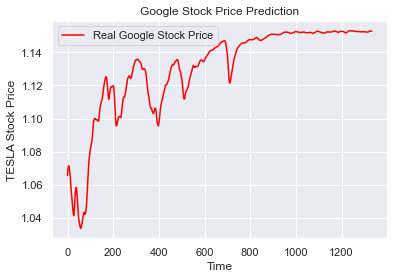

86.01734496965764


In [15]:
# Visualising the results
plt.plot(predicted_stock_price, color = "red", label = "Real Google Stock Price")
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()
print(mean_squared_error(df_GOOG[split_index:-20].loc[:, ['adj_close']].values, predicted_stock_price, squared = False))

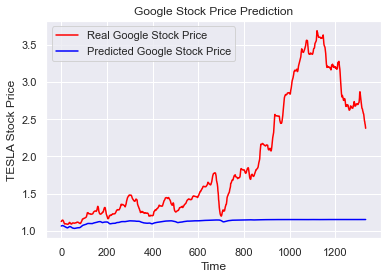

ValueError: Found input variables with inconsistent numbers of samples: [1333, 1334]

In [16]:
# Visualising the results
plt.plot(y_test, color = "red", label = "Real Google Stock Price")
plt.plot(predicted_stock_price, color = "blue", label = "Predicted Google Stock Price")
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()
print(mean_squared_error(df_GOOG[split_index:-21].loc[:, ['adj_close']].values, predicted_stock_price, squared = False))

As it can be seen, the model performs well until around timestep 850. Afterwards, however, it is not following the rising trend of the stock. This can serve as an indication that in this time period there are other influences for the stock to rise. We will explore a second model which calculates the stock price change day-to-day to observe if it will perform better.

#### Difference model

In [18]:
X_train, X_test, y_train, normaliser, split_index, days_prior = data_preprocessing(df_GOOG, 21, 0.7, 'difference')
model = build_lstm(X_train, y_train)
predicted_stock_price = model.predict(X_test)
predicted_stock_price = normaliser.inverse_transform(predicted_stock_price)

Epoch 1/25
98/98 [==============================] - 6s 21ms/step - loss: 0.0059
Epoch 2/25
98/98 [==============================] - 2s 21ms/step - loss: 0.0029
Epoch 3/25
98/98 [==============================] - 2s 20ms/step - loss: 0.0029
Epoch 4/25
98/98 [==============================] - 2s 20ms/step - loss: 0.0027
Epoch 5/25
98/98 [==============================] - 2s 20ms/step - loss: 0.0028
Epoch 6/25
98/98 [==============================] - 2s 20ms/step - loss: 0.0027
Epoch 7/25
98/98 [==============================] - 2s 20ms/step - loss: 0.0027
Epoch 8/25
98/98 [==============================] - 2s 20ms/step - loss: 0.0027
Epoch 9/25
98/98 [==============================] - 2s 20ms/step - loss: 0.0027
Epoch 10/25
98/98 [==============================] - 2s 20ms/step - loss: 0.0025
Epoch 11/25
98/98 [==============================] - 2s 20ms/step - loss: 0.0026
Epoch 12/25
98/98 [==============================] - 2s 20ms/step - loss: 0.0026
Epoch 13/25
98/98 [==================

In [22]:
max(predicted_stock_price)

array([0.05562302], dtype=float32)

In [16]:
df_GOOG[split_index:-days_prior].loc[:, ['adj_close']].values[0][0]

45.98099899291992

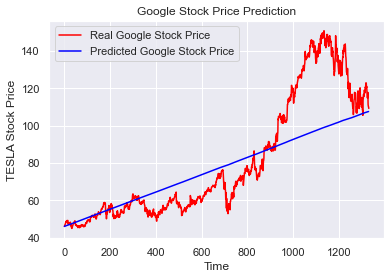

ValueError: Found input variables with inconsistent numbers of samples: [1333, 1332]

In [19]:
new_price = df_GOOG[split_index:-days_prior].loc[:, ['adj_close']].values[0][0]
predicted_price = []
for i in predicted_stock_price:
    new_price = new_price + i
    predicted_price.append(new_price)
# Visualising the results
plt.plot(df_GOOG[split_index:-days_prior].loc[:, ['adj_close']].values, color = "red", label = "Real Google Stock Price")
plt.plot(predicted_price, color = "blue", label = "Predicted Google Stock Price")
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()
print(mean_squared_error(df_GOOG[split_index:-21].loc[:, ['adj_close']].values, predicted_stock_price, squared = False))

In [19]:
#Setting of seed (to maintain constant result)
tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(21, 10), name='input_for_lstm')

inputs = LSTM(21, name='first_layer', return_sequences = True)(lstm_input)

inputs = Dropout(0.1, name='first_dropout_layer')(inputs)
inputs = LSTM(32, name='lstm_1')(inputs)
inputs = Dropout(0.05, name='lstm_dropout_1')(inputs) #Dropout layers to prevent overfitting
inputs = Dense(32, name='first_dense_layer')(inputs)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(lr = 0.002)

model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=25, shuffle=True, validation_split = 0.1)

Epoch 1/25
189/189 [==============================] - 5s 12ms/step - loss: 0.0976 - val_loss: 0.1538
Epoch 2/25
189/189 [==============================] - 2s 9ms/step - loss: 0.0964 - val_loss: 0.1539
Epoch 3/25
189/189 [==============================] - 2s 9ms/step - loss: 0.0962 - val_loss: 0.1542
Epoch 4/25
189/189 [==============================] - 2s 9ms/step - loss: 0.0961 - val_loss: 0.1561
Epoch 5/25
189/189 [==============================] - 2s 9ms/step - loss: 0.0958 - val_loss: 0.1545
Epoch 6/25
189/189 [==============================] - 2s 10ms/step - loss: 0.0958 - val_loss: 0.1547
Epoch 7/25
189/189 [==============================] - 2s 9ms/step - loss: 0.0959 - val_loss: 0.1547
Epoch 8/25
189/189 [==============================] - 2s 9ms/step - loss: 0.0958 - val_loss: 0.1542
Epoch 9/25
189/189 [==============================] - 2s 9ms/step - loss: 0.0958 - val_loss: 0.1544
Epoch 10/25
189/189 [==============================] - 2s 10ms/step - loss: 0.0957 - val_loss: 0.1

In [12]:
# history_points = 21
# y_normaliser = preprocessing.MinMaxScaler()
# next_day_close_values = np.array([train_data['adj_close'][i + history_points].copy() for i in range(len(train_data) - history_points)])
# next_day_close_values = np.expand_dims(next_day_close_values, -1)

In [14]:
# next_day_close_values = np.array([train_data['adj_close'][i + history_points].copy() for i in range(len(train_data) - history_points)])
# next_day_close_values

array([ 4.53251123,  4.48220015,  4.46825218, ..., 46.61100006,
       46.85400009, 47.15000153])

In [15]:
# next_day_close_values = np.expand_dims(next_day_close_values, -1)
# next_day_close_values

array([[ 4.53251123],
       [ 4.48220015],
       [ 4.46825218],
       ...,
       [46.61100006],
       [46.85400009],
       [47.15000153]])

In [17]:
# y_normaliser.fit(next_day_close_values)

MinMaxScaler()

In [34]:
y_pred = model.predict(X_test)

42/42 [==============================] - 0s 3ms/step


In [37]:
y_pred

array([4.3127213, 4.312695 , 4.3127003, ..., 4.3173494, 4.3172226,
       4.31719  ], dtype=float32)

42/42 [==============================] - 0s 3ms/step
4.778132352859906


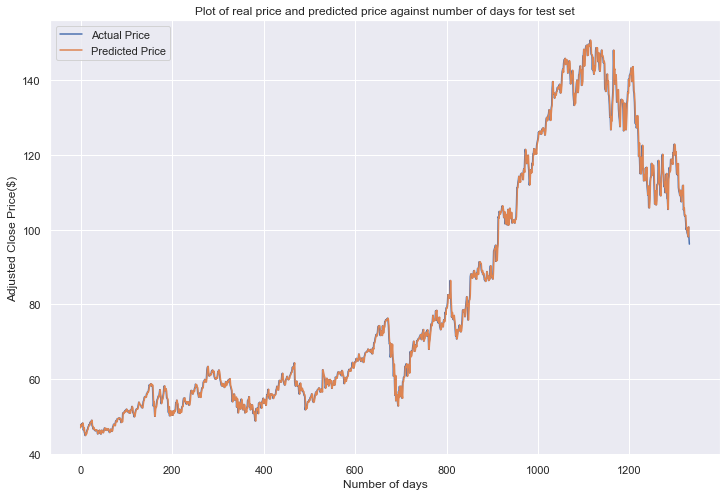

In [38]:
#prediction of model
y_pred = model.predict(X_test)
y_pred = y_normaliser.inverse_transform(y_pred)

y_pred = y_pred.flatten()

#actual represents the test set's actual stock prices
actual = np.array([df_GOOG[split_index:]['adj_close'][i + 21].copy() for i in range(len(df_GOOG[split_index:]) - 21)])

temp_actual = actual[:-2]

#Adding each actual price at time t with the predicted difference to get a predicted price at time t + 1
new = np.add(temp_actual, y_pred)

plt.gcf().set_size_inches(12, 8, forward=True)
plt.title('Plot of real price and predicted price against number of days for test set')
plt.xlabel('Number of days')
plt.ylabel('Adjusted Close Price($)')

plt.plot(actual[1:], label='Actual Price')
plt.plot(new - 4.31, label='Predicted Price')

print(mean_squared_error(actual[2:], new, squared = False))

#plotting of model  
plt.legend(['Actual Price', 'Predicted Price'])


plt.show()